In [83]:
from earlyexitnet.training_tools.train import get_model
from earlyexitnet.tools import load_model, CIFAR10DataColl
import torch

model_path = '../../trained_models/b_lenet_cifar10.pth'
model_name = "b_lenet_cifar"

# model_path = '../../earlyexitnet/trained_models/resnet8_2ee_230721.pth'
# model_name = "resnet8_2ee"
model = get_model(model_name)
load_model(model, model_path,device=torch.device('cuda:0'))

Model done: b_lenet_cifar


In [85]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
#plt.switch_backend('WebAgg')
#%matplotlib widget
import numpy as np

BATCH_SIZE = 1000

datacoll = CIFAR10DataColl(batch_size_train=BATCH_SIZE, v_split=0.2)

from earlyexitnet.testing_tools.test import Tester
import json
from datetime import datetime as dt


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def compute_and_savevalues():
    # shorthand fn for running testing funcs on model
    # BUT using training data instead of test data
    train_dl = datacoll.get_train_dl() # get dataloader
    # create test obj for doing the conf tests and getting the stats
    tester = Tester(model, train_dl, exits=2, 
                    conf_funcs=[0,1,2,3,4], 
                    top1acc_thresholds=[0.6,0],
                    entropy_thresholds=[0.025, 1000000],
                    device=torch.device('cuda:0'), save_raw=True)
    # run tests
    tester.test()
    # pull results dict
    test_res = tester.get_stats()
    # get timestamp
    ts = dt.now().strftime("%Y-%m-%d_%H%M%S")
    # save the results to a json file
    with open(f'../../model-outputs/{model_name}_cifar10_raw_train_output_{ts}.json','a') as file:
        file.write(json.dumps(test_res))
    return test_res

import json
loadFromFile = False
# compute the results using the loaded model or load them from a file
if loadFromFile:
  json_file = '../../model-outputs/resnet8_2ee_cifar10_raw_train_output_280723-12-18.json'
  with open(json_file) as json_data:
    test_res = json.load(json_data)
else:
  test_res = compute_and_savevalues()  

# load the raw outputs from the model
raw_results = torch.Tensor(test_res['raw_layer'])
# load the ground truth index for each class
correct_indices = torch.Tensor(test_res['true_indices'])

# compare the results to the ground truth, provides bool mask
correct_predictions = (raw_results.argmax(-1) == correct_indices)
# 2 exits by num inputs, 2 exits by num samples by last linear layer output(NOT sftmax)
correct_predictions.shape, raw_results.shape

In [86]:
train_dl = datacoll.get_train_dl() # get dataloader

tester = Tester(model, train_dl, exits=2, 
                conf_funcs=[0,1,2,3,4], 
                top1acc_thresholds=[0.6,0],
                entropy_thresholds=[0.2, 1000000],
                device=torch.device('cuda:0'), save_raw=True)

#tester.raw_softmax

Saving raw values, test will take longer.
Running on device: cuda:0


In [87]:
tester.test()

Test of length 40 starting:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:31<00:00, 1282.95samples/s]

### TEST FINISHED ###
--- _thr_entropy ---
Exit percentages: [0.0357, 0.9643]
Accuracy: [0.9320728291316527, 0.4673597428186249]
Total Accuracy: 0.483950
--- _thr_max_softmax ---
Exit percentages: [0.401775, 0.598225]
Accuracy: [0.6784892041565553, 0.39863763634084165]
Total Accuracy: 0.511075
--- _thr_max_softmax_fast ---
Exit percentages: [0.171875, 0.828125]
Accuracy: [0.8005818181818182, 0.43544150943396226]
Total Accuracy: 0.498200
--- _thr_max_softmax_fast_noTrunc ---
Exit percentages: [0.2091, 0.7909]
Accuracy: [0.7847919655667145, 0.42505373624984194]
Total Accuracy: 0.500275
--- _thr_max_softmax_fast_sub ---
Exit percentages: [0.136475, 0.863525]
Accuracy: [0.8360505587103865, 0.4400856952607047]
Total Accuracy: 0.494125
########
Total Accuracy: [0.482525, 0.481775]


In [88]:
test_res = tester.get_stats()

# load the raw outputs from the model
raw_results = torch.Tensor(test_res['raw_layer'])
# load the ground truth index for each class
ground_truth = torch.Tensor(test_res['true_indices'])

# compare the results to the ground truth, provides bool mask
correct_predictions = (raw_results.argmax(-1) == ground_truth)
# 2 exits by num inputs, 2 exits by num samples by last linear layer output(NOT sftmax)
correct_predictions.shape, raw_results.shape

(torch.Size([2, 40000]), torch.Size([2, 40000, 10]))

In [89]:
import earlyexitnet.data_analysis.graphs as hp
import sklearn

classes_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

conf_list = [
        "_thr_entropy",
        "_thr_max_softmax",
        "_thr_max_softmax_fast",
        "_thr_max_softmax_fast_noTrunc",
        "_thr_max_softmax_fast_sub",
        "_thr_max_softmax_fast_sub_bitAcc"
]
top1_sftmx = torch.Tensor(test_res['conf_metrics']['_thr_max_softmax']['raw_softmax'])

rr = raw_results.numpy() # [exits, batch size, class dist]
flattened = rr.swapaxes(1,2).reshape(2,-1)
chosen_class = np.concatenate((rr.argmax(-1).copy(), rr.argmax(-1).copy()), axis=-1)
index = np.concatenate((np.full((2,40000), 0), np.full((2,40000), 1)), axis=-1)
correct_classif = np.concatenate((correct_predictions, correct_predictions), axis=-1)
for i in range(10-2):
    chosen_class = np.concatenate(
        (chosen_class, rr.argmax(-1)), axis=-1
    )
    index = np.concatenate(
        (index, np.full((2,40000), i+2)), axis=-1
    )
    correct_classif = np.concatenate(
        (correct_classif, correct_predictions), axis=-1
    )
    

In [90]:
# individual inputs raw results over 10 classes seems to get spread across the indices
# meaning that the 0,0,0 = 0,0 BUT 0,0,1 = 0,40000
# this has the effect of grouping each logit index with the others, duplicating a lot of info
#flattened = np.asarray([[y[i] for i in range(10) for y in x] for x in rr])
#correct_class = np.asarray([[y for i in range(10) for y in x] for x in np.argmax(rr, -1)])
#class_index = np.asarray([[i for i in range(10) for y in x] for x in np.argmax(rr, -1)])
#misclassified = np.asarray([[y for i in range(10) for y in x] for x in correct_predictions])

# [class index of this raw value from logit, raw logit value, chosen class (from argmax), misclassified (0 is incorrect, 1 is correct)
comb = np.stack(
    (index, flattened, chosen_class, correct_classif), -1
)

#comb = np.stack((class_index,
#                 flattened, 
#                 correct_class,
#                 misclassified),-1)

classes_grouped = hp.group_by(comb)

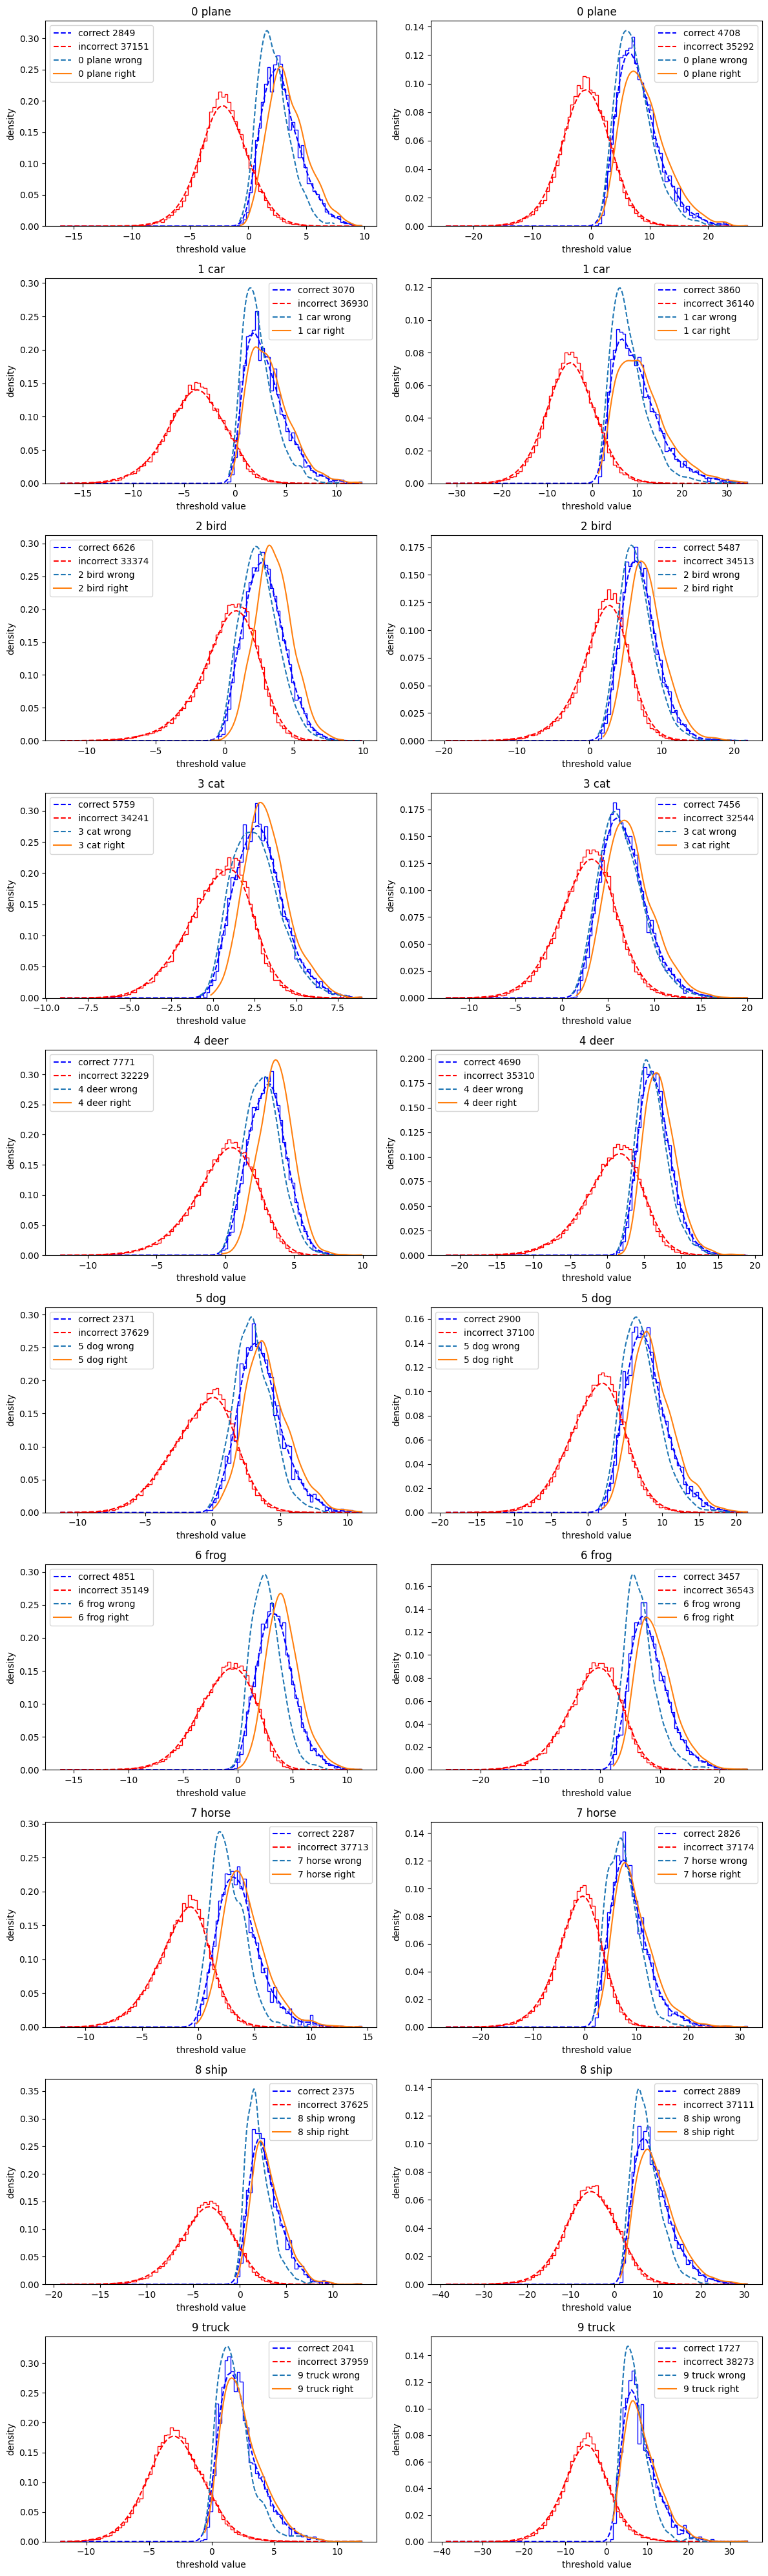

In [91]:
#import helper.graphs as hp
#%matplotlib widget
#from importlib import reload
#reload(hp)

#early_exit = classes_grouped[0]
# print(early_exit[0])
num_exits=2
num_classes=10

fig, ax_grp = plt.subplots(nrows=10,ncols=2)

for k, ex in enumerate(classes_grouped):
    for i, rec_class in enumerate(ex):

      ax = ax_grp[i][k]
      
      rec_class = np.array(rec_class)
      
      # plot all values produce by single class output
      hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None)
    
      wrong_class = rec_class[np.invert(np.array(rec_class[:,2],dtype=bool))]
      # # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None, right_col='green', wrong_col='orange')
      ismax = np.array(wrong_class[:,1]) == i
      hp.plot_hist_kernel(ax, wrong_class[:,0][ismax], label=f"{i} {classes_labels[i]} wrong", hist=False)
      right_class = rec_class[np.array(rec_class[:,2],dtype=bool)]
      # # hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None, right_col='green', wrong_col='orange')
      ismax = np.array(right_class[:,1]) == i
      hp.plot_hist_kernel(ax, right_class[:,0][ismax], label=f"{i} {classes_labels[i]} right", hist=False, ls='-')
      ax.set_title(f"{i} {classes_labels[i]}")
      ax.legend()
fig.set_size_inches(6 * num_exits, 4 * num_classes)
fig.tight_layout()
plt.show()

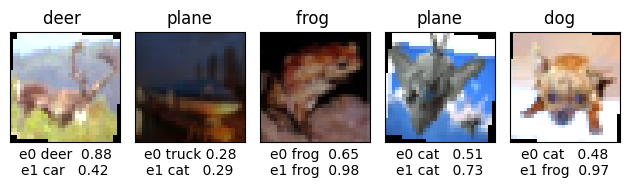

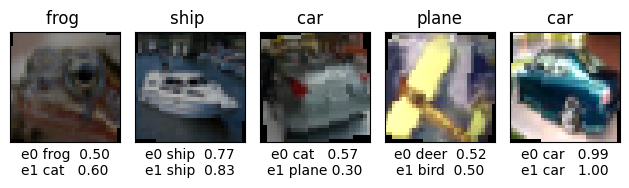

In [92]:
# SHOW THE MODEL WORKING
# %matplotlib ipympl needs ipywidgets
import math
from IPython.core.debugger import set_trace

test_dl = datacoll.get_train_dl()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ncols=1, label=None, caption=None):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.to('cpu').numpy()
    num_img = npimg.shape[0]
    
    nrows = math.ceil(num_img / ncols)
    
    img_track = 0
    
    for row in range(nrows):
        fig, axs = plt.subplots(nrows=1, ncols=ncols,
                                subplot_kw={'xticks': [], 'yticks': []})

        if row > 5:
            break
        
        for ax in axs:
            if img_track < num_img:
                ax.imshow(np.transpose(npimg[img_track], (1, 2, 0)))
                if label is not None:
                    ax.set_title(label[img_track])
                if caption is not None:
                    ax.set_xlabel(caption[img_track])
            img_track += 1
            
        plt.tight_layout()
        # plt.imshow(np.transpose(npimg, (1, 1, 1)))
        plt.show()

def getcaption(images, model):
    model.eval()
    #captions = ['' for i in range(BATCH_SIZE)]
    captions = ['' for i in range(10)]
    with torch.no_grad():
        result = model.forward(images)
        sftmx = torch.max(torch.softmax(result, dim=-1),dim=-1).values
        res_max = result.max(dim=-1).values
        res_arg_max = result.max(dim=-1).indices
        for exit_num, (max, arg_max) in enumerate(zip(sftmx, res_arg_max)):
            for i, (max_val, index) in enumerate(zip(max, arg_max)):
                captions[i] += f"e{exit_num} {classes[index]:5s} {max_val:.02f}"
                if exit_num != model.exit_num - 1:
                    captions[i] += '\n'
    return captions
# get some random training images
dataiter = iter(test_dl)
images, labels = next(dataiter)
images.shape, labels.shape
images[:10].shape, labels[:10]

images = images[:10].to('cuda:0')
labels = labels[:10].to('cuda:0')


# show images
imshow(images, ncols=5, label=[f'{classes[label]:5s}' for label in labels], caption=getcaption(images, model))
